In [53]:
import torch

CONTENT_FILES = './input/bdl'
STYLE_FILES = './input/clb'


windowSize = 48         # the input width of the model
vecLen = 128            # length of vector generated by siamese vector
shape = 24              # length of time axis of split specrograms to feed to generator            

batch_size = 32         #batch size



# If gpu is available
if torch.cuda.is_available():  
    device = torch.device('cuda')
else:
    device = torch.device('cpu')



# Reading

loaded 1132 files from ./input/bdl
loaded 1132 files from ./input/clb
sampleRate: 22050


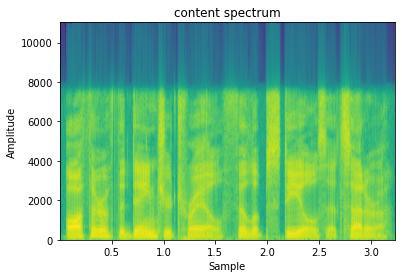

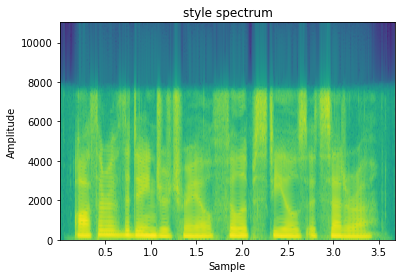

In [72]:


from TraVeLGAN.processing import wav2spectrum, sampleRate
from utils import loadFile
from glob import glob
import torch

def loadData(path):
    files = glob(f'{path}/*.wav')
    data = []
    for file in files:
        x= loadFile(file)
        data.append(x)
    print(f'loaded {len(files)} files from {path}')
    return data


def transformData(Xs):
    ret = []
    for x in Xs:
        ret.append(wav2spectrum(x))
    return ret
    

x_content = loadData(CONTENT_FILES)
x_style = loadData(STYLE_FILES)


a_content = transformData(x_content)
a_style = transformData(x_style)


print(f'sampleRate: {sampleRate}')

plot_spectrogram_with_raw_signal(x_content[0], sampleRate, 'content spectrum')
plot_spectrogram_with_raw_signal(x_style[0], sampleRate, 'style spectrum')

H_Spec = a_content[0].shape[0]


# Making Dataset

In [75]:
from torch.utils.data import Dataset, DataLoader
import numpy as np

class myDataset(Dataset):
    def __init__(self, content, style, sampleNumber = 50):
        self.style = []
        self.content = []
        for c, s in zip(content, style):
            H_S, W_S = s.shape
            H_C, W_C = c.shape 
            indices_C = np.random.randint(W_C - windowSize, size = sampleNumber)
            indices_S = np.random.randint(W_S - windowSize, size = sampleNumber)
        
            for i in indices_C:
                tensor = torch.tensor(c[None, :, i: i + windowSize])
                self.content.append(tensor)

            for i in indices_S:
                tensor = torch.tensor(s[None, :, i: i + windowSize])
                self.style.append(tensor)

    def __getitem__(self, index):
        return self.content[index], self.style[index]

    def __len__(self):
        return len(self.content)

dataset = myDataset(a_content, a_style)

train_loader = DataLoader(
    dataset, batch_size = batch_size
)

print(f'Load {len(dataset)} samples')


Load 56600 samples


# Setting

In [77]:

learning_rate_S = 0.00001
learning_rate_G = 0.00001
learning_rate_D = 0.000005

"""
L_S = beta L_{(G, S), TraVeL} + gamma L_{S, margin}
L_G = L_{G, adv} + alpha L_{G, id} + beta L_{(G, S), TraVeL}
L_D = L_{D, adv}
"""

alpha = 1.0
delta = 2.0
beta = 10.0
gamma = 10.0

max_epochs = 30      # maximum epochs

load_model_path = './saved_model/test3'  # path of the pretrained model
saved_experiment_path = './saved_model/test4'   # path of the saved model

if not os.path.exists(saved_experiment_path):
    os.mkdir(saved_experiment_path)

    
plot_spec = False    # plot spectrum when training 
saved_epoch = 3      # save model period

pretrained = True   # If loading the pretrained model 



# Training

In [80]:

from TraVeLGAN.models import Siamese, Generater, Discriminator
from utils import plot_spectrogram_with_raw_signal
from TraVeLGAN.processing import spectrum2wav, hop
from TraVeLGAN.loss import *
import torch.optim as optim
from tqdm import tqdm
import pickle as pkl
import torch 
import os

# Crop function for training
def crop(x):
    return x[:, :, :, :shape], x[:, :, :, shape:]


model_S = Siamese(input_size = (1, hop, shape), output_size = vecLen)
model_G = Generater(input_size = (1, hop, shape))
model_D = Discriminator(input_size = (1, hop, windowSize))


# load pretrained model
if pretrained :
    model_S.load_state_dict(torch.load(os.path.join(load_model_path, 'model_S.pt')))
    model_G.load_state_dict(torch.load(os.path.join(load_model_path, 'model_G.pt')))
    model_D.load_state_dict(torch.load(os.path.join(load_model_path, 'model_D.pt')))


optimizer_S = optim.Adam(
    model_S.parameters(),
    lr = learning_rate_S
)

optimizer_G = optim.Adam(
    model_G.parameters(),
    lr = learning_rate_G
)

optimizer_D = optim.Adam(
    model_D.parameters(),
    lr = learning_rate_D
)


model_S.to(device)
model_G.to(device)
model_D.to(device)


model_S.train()
model_G.train()
model_D.train()

gupt = 3

losses = {
    'loss_id': [],
    'loss_m': [],
    'loss_dr': [],
    'loss_df': [],
    'loss_g': [],
    'loss_S': [],
    'loss_G': [],
    'loss_D': []
}

for epoch in range(1, max_epochs + 1):
    
    
    loss_g_epoch = 0.0
    loss_m_epoch = 0.0
    loss_id_epoch = 0.0
    loss_dr_epoch = 0.0
    loss_df_epoch = 0.0

    loss_S_epoch = 0.0
    loss_G_epoch = 0.0
    loss_D_epoch = 0.0
    


    with tqdm(train_loader, unit = 'batch') as tepoch:
        for i, (x, y) in enumerate(tepoch):
            
            tepoch.set_description(f'Training Epoch {epoch:03d}/{max_epochs:03d}')

            x = x.to(device)
            y = y.to(device)

            x1, x2 = crop(x)
            y1, y2 = crop(y)

            if i % gupt == 0: # Train all

                optimizer_S.zero_grad()
                optimizer_G.zero_grad()
                optimizer_D.zero_grad()

                gen_x_1 = model_G(x1)
                gen_x_2 = model_G(x2)
                
                gen_y_1 = model_G(y1)
                gen_y_2 = model_G(y2)

                gen = torch.cat([gen_x_1, gen_x_2], dim = -1)

                iden_gen = model_D(gen)
                iden_ori = model_D(y)

                siam_x_1_gen = model_S(gen_x_1)
                siam_x_2_gen = model_S(gen_x_2)

                siam_x_1 = model_S(x1)
                siam_x_2 = model_S(x2)


                # identity mapping loss
                loss_id = (mse(y1, gen_y_1) + mse(y2, gen_y_2)) / 2.0

                
                # margin loss
                loss_m = loss_margin(siam_x_1, siam_x_2, delta)


                # travel loss
                loss_t = loss_travel(siam_x_1, siam_x_1_gen, siam_x_2, siam_x_2_gen)


                # generator and critic losses
                loss_g = g_loss_f(iden_gen)
                loss_dr = d_loss_r(iden_ori)
                loss_df = d_loss_f(iden_gen)
                

                loss_D = (loss_dr + loss_df) / 2

                loss_G = loss_g + alpha * loss_id + beta * loss_t

                loss_S = beta * loss_t + gamma * loss_m


                loss_g_epoch += loss_g.item()
                loss_m_epoch += loss_m.item()
                loss_id_epoch += loss_id.item()
                loss_dr_epoch += loss_dr.item()
                loss_df_epoch += loss_df.item()
                
                loss_S_epoch += loss_S.item()
                loss_G_epoch += loss_G.item()
                loss_D_epoch += loss_D.item()
                


                loss_S.backward(retain_graph = True)
                loss_G.backward(retain_graph = True)
                loss_D.backward()       
                
                optimizer_S.step()
                optimizer_G.step()
                optimizer_D.step()


            else: # Train Critic only
                
                optimizer_D.zero_grad()

                gen_x_1 = model_G(x1)
                gen_x_2 = model_G(x2)

                gen = torch.cat([gen_x_1, gen_x_2], dim = -1)

                iden_gen = model_D(gen)
                iden_ori = model_D(y)

                # zero tensor
                zero = torch.zeros(vecLen, device = device)

                loss_dr = d_loss_r(iden_ori)
                loss_df = d_loss_f(iden_gen)

                loss = loss_dr + loss_df

                loss_dr_epoch += loss_dr.item()
                loss_df_epoch += loss_df.item()

                loss_D += loss.item()

                loss.backward()
                optimizer_D.step()
            
    if epoch % saved_epoch == 0 :

        epoch_path = os.path.join(saved_experiment_path, f'epoch_{epoch}')

        if not os.path.exists(epoch_path):
            os.mkdir(epoch_path)
 
        index = np.random.randint(len(a_content))

        if plot_spec:
            plot_spectrogram_with_raw_signal(x_content[index], sampleRate, 'input spectrum')

        a_input = a_content[index]
        H, W = a_input.shape

        W_output = W - (W % shape) 
        a_output = np.zeros((H, W_output))

        tensor_input = torch.tensor(a_input[:, :W_output])
        tensor_input = tensor_input.to(device)

        model_G.eval()

        for i in range(0, W_output, shape):
            a_output[:, i: i + shape] = model_G(tensor_input[:, i:i + shape].view(1, 1, H, shape)).detach().cpu().numpy()

        x_output = spectrum2wav(a_output)
        
        if plot_spec:
            plot_spectrogram_with_raw_signal(x_output, sampleRate, 'output spectrum')


        # saved generated waveform
        x_output = scale_audio(x_output, 20)
        writeFile(os.path.join(epoch_path, 'ori.wav'), x_content[index])
        writeFile(os.path.join(epoch_path, 'gen.wav'), x_output)

        # save models
        torch.save(model_S.state_dict(), os.path.join(epoch_path, 'model_S.pt'))
        torch.save(model_G.state_dict(), os.path.join(epoch_path, 'model_G.pt'))
        torch.save(model_D.state_dict(), os.path.join(epoch_path, 'model_D.pt'))

        print(f'Save model and generate waveform at epoch {epoch}, total loss: {loss_S_epoch + loss_G_epoch + loss_D_epoch}')
        
        model_G.train()



    losses['loss_g'].append(loss_g_epoch)
    losses['loss_m'].append(loss_m_epoch)
    losses['loss_id'].append(loss_id_epoch)
    losses['loss_dr'].append(loss_dr_epoch)
    losses['loss_df'].append(loss_df_epoch)

    
    losses['loss_S'].append(loss_S_epoch)
    losses['loss_G'].append(loss_G_epoch)
    losses['loss_D'].append(loss_D_epoch)
    
    

info = {
    'alpha': alpha,
    'beta': beta,
    'delta': delta,
    'gamma': gamma,
    'loss': losses,
    'epochs': max_epochs,
    'learning_rate_S': learning_rate_S,
    'learning_rate_G': learning_rate_G,
    'learning_rate_D': learning_rate_D,
    'input_shape': (1, H_Spec, windowSize),
    'vecLen': vecLen,
    'batch_size': batch_size,
    'saved_model_path': saved_experiment_path,
    'load_model_path': load_model_path,
    'pretrained': pretrained
}

with open(os.path.join(saved_experiment_path, 'train_info.pkl'), 'wb') as f:
    pkl.dump(info, f)

torch.save(model_S.state_dict(), os.path.join(saved_experiment_path, 'model_S.pt'))
torch.save(model_G.state_dict(), os.path.join(saved_experiment_path, 'model_G.pt'))
torch.save(model_D.state_dict(), os.path.join(saved_experiment_path, 'model_D.pt'))

 

Training Epoch 003/030: 100%|██████████| 1769/1769 [02:50<00:00, 10.36batch/s]


Save model and generate waveform at epoch 3, total loss: 12270.224124133587


Training Epoch 006/030: 100%|██████████| 1769/1769 [02:46<00:00, 10.65batch/s]


Save model and generate waveform at epoch 6, total loss: 12252.215770304203


Training Epoch 009/030: 100%|██████████| 1769/1769 [02:54<00:00, 10.16batch/s]


Save model and generate waveform at epoch 9, total loss: 12243.562707781792


Training Epoch 012/030: 100%|██████████| 1769/1769 [02:59<00:00,  9.86batch/s]


Save model and generate waveform at epoch 12, total loss: 12245.31655460596


Training Epoch 015/030: 100%|██████████| 1769/1769 [02:57<00:00,  9.97batch/s]


Save model and generate waveform at epoch 15, total loss: 12218.008852899075


Training Epoch 018/030: 100%|██████████| 1769/1769 [02:52<00:00, 10.26batch/s]


Save model and generate waveform at epoch 18, total loss: 12247.23248744011


Training Epoch 021/030: 100%|██████████| 1769/1769 [03:00<00:00,  9.81batch/s]


Save model and generate waveform at epoch 21, total loss: 12241.434507906437


Training Epoch 024/030: 100%|██████████| 1769/1769 [02:51<00:00, 10.30batch/s]


Save model and generate waveform at epoch 24, total loss: 12210.31439512968


Training Epoch 027/030: 100%|██████████| 1769/1769 [02:59<00:00,  9.86batch/s]


Save model and generate waveform at epoch 27, total loss: 12204.435624480247


Training Epoch 030/030: 100%|██████████| 1769/1769 [02:56<00:00, 10.04batch/s]


Save model and generate waveform at epoch 30, total loss: 12226.853070497513


# Show training process

[2418.5914499759674, 2425.54239654541, 2435.208719968796, 2442.5456581115723, 2446.8108102083206, 2457.3003894090652, 2462.8456081151962, 2470.9886651039124, 2479.5317475795746, 2489.4198895692825, 2499.39941573143, 2504.8391289711, 2512.8413400650024, 2519.3052134513855, 2527.045688509941, 2533.5843527317047, 2536.249080657959, 2540.0004987716675, 2543.0219177007675, 2547.000850915909, 2552.369262576103, 2556.8857523202896, 2567.0572514533997, 2570.7219746112823, 2575.2271032333374, 2578.6864389181137, 2571.773530483246, 2577.337013244629, 2584.3242391347885, 2591.5647846460342]


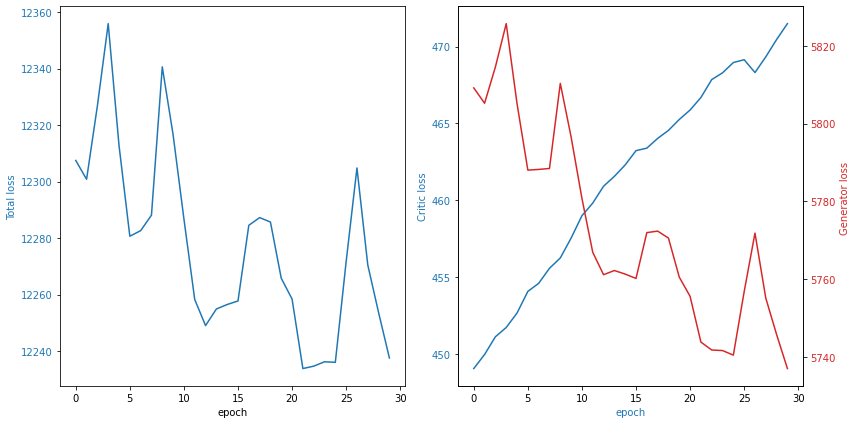

In [71]:

# print(losses['loss_g'])

print(losses['loss_df'])

total_loss = np.array(losses['loss_S']) + np.array(losses['loss_G']) + np.array(losses['loss_D'])

plot_curve(losses['loss_D'], losses['loss_G'], total_loss, 'Critic loss', 'Generator loss ', 'Total loss', False)
# plot_curve(losses['loss_g'])
# print(losses['loss_m'])
# print(losses['loss_g'])
# print(losses['loss_GS'])




# Load Model

In [9]:

from TraVeLGAN.models import Siamese, Generater, Discriminator
from TraVeLGAN.processing import hop


model_S = Siamese(input_size = (1, hop, windowSize // 3), output_size = vecLen)
model_G = Generater(input_size = (1, hop, windowSize // 3))
model_D = Discriminator(input_size = (1, hop, windowSize))


model_S.load_state_dict(torch.load(os.path.join(load_model_path, 'model_S.pt')))
model_G.load_state_dict(torch.load(os.path.join(load_model_path, 'model_G.pt')))
model_D.load_state_dict(torch.load(os.path.join(load_model_path, 'model_D.pt')))


<All keys matched successfully>

# Generate output



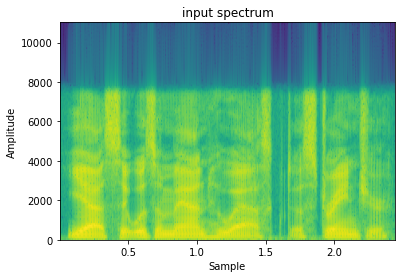

192 281


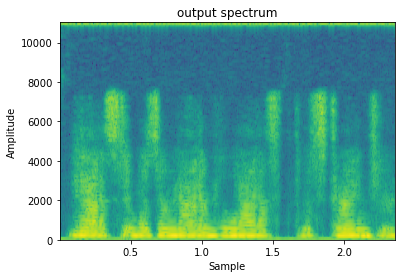

In [69]:

# from preprocess import *
from utils import *

INPUT_FILE = './input/bdl/arctic_a0063.wav'

N_FFT = 512


x_input = loadFile(INPUT_FILE)
a_input = wav2spectrum(x_input)

plot_spectrogram_with_raw_signal(x_input, sampleRate, 'input spectrum')


H, W = a_input.shape
print(H, W)

w = windowSize // 3

W_output = W - (W % w) 
a_output = np.zeros((H, W_output))


# tensor_input = torch.transpose(torch.transpose(torch.tensor(a_input[:, :W_output]) ,1, 0).reshape(-1, 1, windowSize, H), -2, -1)
tensor_input = torch.tensor(a_input[:, :W_output])


model_G.to(device)
tensor_input = tensor_input.to(device)

model_G.eval()

for i in range(0, W_output, w):
    a_output[:, i: i + w] = model_G(tensor_input[:, i:i + w].view(1, 1, H, w)).detach().cpu().numpy()

# a_output = model_G(tensor_input).reshape(H, W_output).detach().cpu().numpy()

# a_output = np.where(a_output == np.inf, 1e9, a_output)
# a_output = np.where(a_output == np.nan, 1e9, a_output)

x_output = spectrum2wav(a_output)

plot_spectrogram_with_raw_signal(x_output, sampleRate, 'output spectrum')



# Save file

In [70]:
import os

filename = 'TraVelGan.wav'

x_output = add_audio(x_output, 40)
writeFile(os.path.join('./output/', filename), x_output)
